In [1]:
import pandas as pd
from rdkit import Chem
from litschnet import LitSchNet
import os
import pickle
from molecule_featurizer import MoleculeFeaturizer
from torch_geometric.data import Batch
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
table = pd.read_csv('../DRD2_Morgan_dataset/excape-db_human_DRD2_randsample.csv', index_col=0)

In [3]:
table

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZKKMMRAFWUBCN-UHFFFAOYNA-N,CHEMBL1834261,1813,A,5.24000,chembl20,771231,9606,DRD2,1171,N1(CCN(CC1)CCCCC=2C=CC(=CC2)OC)CC=3OC=4C(C3)=C...
1,AZORJLGCYRQCSX-UHFFFAOYNA-N,CHEMBL562624,1813,A,7.00000,chembl20,577523,9606,DRD2,1171,C=1C=C(N2CCN(CCN3CCC(CC3)C(F)(F)F)C2=O)C=C(C1)Cl
2,AZTUVZSKZZUSFU-YOKYMGTQNA-N,CHEMBL1688997,1813,A,7.23000,chembl20,735243,9606,DRD2,1171,C1CN(CCN1C/C=C/CNC(C=2C=CC(=CC2)OCCOCCF)=O)C=3...
3,BGJDVOKZOHLJPT-LILDFLRNNA-N,21462980,1813,A,6.19382,pubchem,61309,9606,DRD2,1171,N1(CCC=2C(C1)=CC=CC2)CC=3C=4C(NC3)=NC=CC4
4,BGJKTPLCXOXWJT-UHFFFAOYNA-N,CHEMBL556035,1813,A,5.68000,chembl20,59785,9606,DRD2,1171,C=1(C(C2(OC1)CCN(CC2)CCC3=CC=CC=C3)=O)C4=CC=C(...
...,...,...,...,...,...,...,...,...,...,...,...
9608,LMYLGRCCWYXICQ-DXNRXMRRNA-N,5829079,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S1C(=NC(C=2C=CN=CC2)=C1)NC(=O)/C=C/C3=CC=CC=C3
9609,MAAJKHWOVKXTPF-UHFFFAOYNA-N,4457031,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S(=O)(=O)(N(CC)CC)C=1C=C(NS(=O)(=O)C2=CC=CC=C2...
9610,CMAKZYKJFVSLBM-WYUMXYHSNA-N,2192547,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,O(C=1C=C(NC(=O)C=2C=CC=CC2)C=C(OC)C1)C
9611,USDVBCAOIYHVBZ-NDKGDYFDNA-N,6456664,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,O(C1=C(N(=O)=O)C=C(C=C1)C)CC(=O)NC2=NOC=C2


In [4]:
mols = Chem.SDMolSupplier('../DRD2_Morgan_dataset/excape-db_human_DRD2_randsample_docked.sdf')

In [5]:
mols = [mol for mol in mols]

In [6]:
len(mols)

223677

In [7]:
source_file_indexes = [int(mol.GetProp('i_m_source_file_index')) for mol in mols]

In [8]:
min(source_file_indexes)

1

In [9]:
max(source_file_indexes)

9613

In [10]:
iteration = 0
experiment_name = f'scaffold_split_{iteration}_new'
if experiment_name in os.listdir('lightning_logs') :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
litschnet = litschnet.to('cuda')
litschnet.eval()

LitSchNet(
  (schnet): SchNet(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [1]:
root = 'data/'
encoder_path = os.path.join(root, 'molecule_encoders.p')
if os.path.exists(encoder_path) : # Load existing encoder
    with open(encoder_path, 'rb') as f:
        mol_encoders = pickle.load(f)
mol_featurizer = MoleculeFeaturizer(mol_encoders)

NameError: name 'os' is not defined

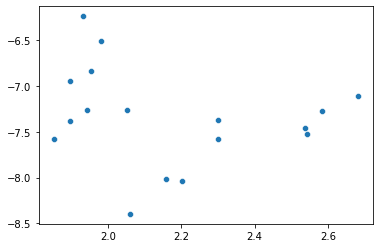

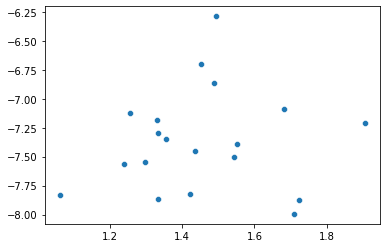

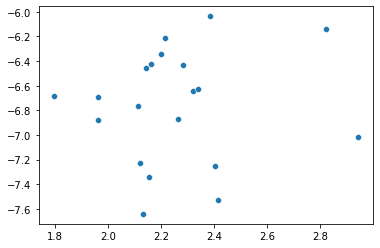

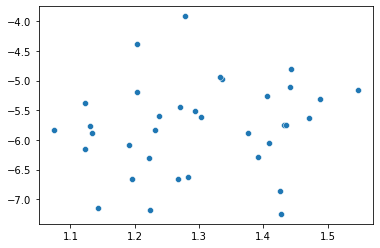

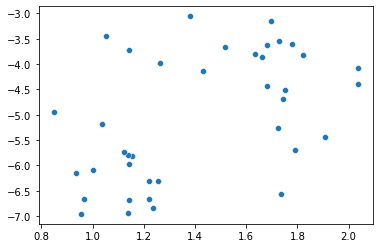

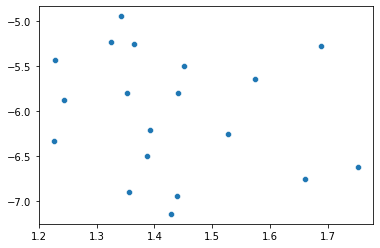

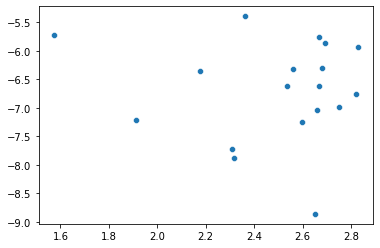

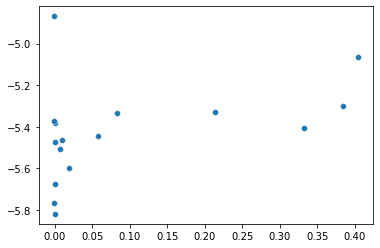

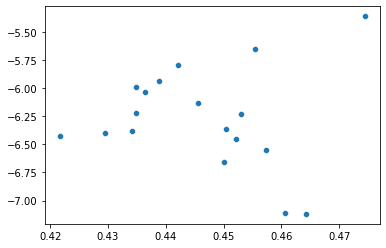

In [12]:
for i in table.index[:10] :
    index = i + 1
    current_mols = [mol for mol in mols if int(mol.GetProp('i_m_source_file_index')) == index]
    if len(current_mols) :
        docking_scores = [float(mol.GetProp('r_i_docking_score')) for mol in current_mols]

        data_list = [mol_featurizer.featurize_mol(mol)[0] for mol in current_mols]
        batch = Batch.from_data_list(data_list)
        batch = batch.to('cuda')
        with torch.no_grad() :
            preds = litschnet(batch).cpu().numpy()
        preds = preds.reshape(-1)
        sns.scatterplot(x=preds, y=docking_scores)
        plt.show()

In [13]:
mols[1].GetPropsAsDict()

{'s_m_entry_id': 31833,
 's_m_entry_name': 'excape-db_human_DRD2_randsample.2497',
 's_m_Source_Path': '/home/morgan/phd/side_projects/Bernhard-BO',
 's_m_Source_File': 'excape-db_human_DRD2_randsample.smi',
 'i_m_Source_File_Index': 2497,
 's_m_source_file': 'ligprep_1.maegz',
 'i_m_source_file_index': 2497,
 'i_lp_mmshare_version': 48012,
 'i_f3d_flags': 0,
 's_epik_input': 'W2NIXTFbY0hdW2NIXVtjSF1bY0hdYzFOKFtDSDJdW0NIMl0yKVtDSDJdW0NIMl1OMltDSDJdW0NIMl1bQ0gyXU9jKFtjSF1bY0hdMylbY0hdW2NIXWMzLWMobjQpbihjKGM0NSlbY0hdW2NIXVtjSF1bY0hdNSlbQ0gyXS9bQ0hdPVtDSF0vW0NIMl1uKGMoYzY3KVtjSF1bY0hdW2NIXVtjSF03KWMobjYpLWM4W2NIXVtjSF1jKFtjSF1bY0hdOClPW0NIMl1bQ0gyXVtDSDJdTjlbQ0gyXVtDSDJdTihbQ0gyXVtDSDJdOSljMVtjSF1bY0hdW2NIXVtjSF1bY0hdMQ==',
 's_epik_cmdline': 'J2VwaWtfcHl0aG9uJywgJy1waHQnLCAnMS4wJywgJy1waCcsICc3LjAnLCAnLW50JywgJy1tYScsICcyMDAnLCAnLWltYWUnLCAnPGluZmlsZS5tYWU+JywgJy1vbWFlJywgJzxvdXRmaWxlLm1hZT4n',
 'r_epik_Ionization_Penalty': '  1.7222',
 'r_epik_Ionization_Penalty_Charging': '  0.9430',
 